In [ ]:
import wfdb
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import (Dense, MaxPool1D, Flatten, Dropout, BatchNormalization,
                                     Conv1D, Input, InputLayer, Bidirectional, LSTM)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Install some packages
install wfdb, wget using pip

In [ ]:
!pip install wfdb

     |████████████████████████████████| 137 kB 13.0 MB/s 
     |████████████████████████████████| 10.3 MB 42.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=1385fba9aaa980077e46865a06f6e11bc67aeb8df8a4445e9e2ab40d9baa05e8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# hamidreza
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset
download MIT-BIH Arrhythmia Database from [here](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip) and unzip

In [ ]:
database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

# download if not exist
if not database_path.exists():
    url = "https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    wget.download(url)

# unzip
with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

100% [........................................................................] 77030320 / 77030320

In [ ]:
# download long term AF Database and unzip
import wget
import zipfile
from pathlib import Path

database_filename_2 = "long-term-af-database-1.0.0.zip"
database_path_2 = Path(database_filename_2)

# download if not exist
if not database_path_2.exists():
    url_2 = "https://physionet.org/static/published-projects/ltafdb/long-term-af-database-1.0.0.zip"
    wget.download(url_2)

# unzip
with zipfile.ZipFile(database_filename_2, 'r') as zip_ref_2:
        zip_ref_2.extractall(".")

 62% [..........................................                          ] 1109590016 / 1776262655100% [....................................................................] 1776262655 / 1776262655

# Define statics
define static variable such as **data_path**, **freq**, ...

In [5]:
data_path = "mit-bih-arrhythmia-database-1.0.0/"
freq = 360
pts = ["100", "101", "102", "103", "104", "105", "106", "107",
       "108", "109", "111", "112", "113", "114", "115", "116",
       "117", "118", "119", "121", "122", "123", "124", "200",
       "201", "202", "203", "205", "207", "208", "209", "210",
       "212", "213", "214", "215", "217", "219", "220", "221",
       "222", "223", "228", "230", "231", "232", "233", "234"]

nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

classes = ['N', 'V', '']

In [ ]:
# define static variable for long term AF Database
data_path_2 = "files/"
freq_2 = 128
pts_2 = [ "00", "01", "03", "05", "06", "07", "08","10","11","12","13","15","16","17","18","19","20","21","22","23","24","25",
       "26","28","30","32","33","34","35","37","38","39","42","43","44","45","47","48", "49","51","53","54","55","56",
       "58","60","62","64","65","68","69","70","71","72","74","75","100","101","102","103","104","105","110","111",
       "112","113","114","115","116","117","118","119","120","121","122","200","201","202","203","204","205","206","207","208"]

nonbeat_2 = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

abnormal_2 = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Data Visualization
Visualize and extract some information from dataset

load all symbols in dataframe

In [ ]:
df = pd.DataFrame()
for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({"sym": values, "val": counts, "pt": [pt]*len(counts)})
    df = pd.concat([df, df_sub], axis=0)

In [ ]:
# for long term AF 
df_2 = pd.DataFrame()
for pt_2 in pts_2:
    file_2 = data_path_2 + pt_2
    annotation_2 = wfdb.rdann(file_2, 'atr')
    sym_2 = annotation_2.symbol
    
    values, counts = np.unique(sym_2, return_counts=True)
    df_sub = pd.DataFrame({"sym": values, "val": counts, "pt": [pt]*len(counts)})
    df = pd.concat([df, df_sub], axis=0)

show number of each symbol in dataset

In [ ]:
df.groupby("sym").val.sum().sort_values(ascending=False)

sym
N    8785925
A     154878
V     139809
+      54995
L       8075
R       7259
/       7028
"       6396
f        982
F        803
~        616
!        472
j        229
x        193
a        150
|        132
Q        122
E        106
J         83
e         16
[          6
]          6
S          2
Name: val, dtype: int64

break dataset into 3 subset:


1.   nonbeats (-1)
2.   normal (0)
3.   abnormal (+1)

then show number of sample in each subset


In [ ]:
df["cat"] = -1
df.loc[df.sym == 'N',"cat"] = 0
df.loc[df.sym.isin(abnormal), "cat"] = 1

df.groupby("cat").val.sum()

cat
-1      62938
 0    8785925
 1     319420
Name: val, dtype: int64

**Define a function for loading a single patient’s signals and annotations**

Note the annotation values are the indices of the signal array

In [ ]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    atr_aux = annotation.aux_note
    
    return p_signal, atr_sym, atr_sample, atr_aux

In [ ]:
# load the ecg from long term AF 
def load_ecg_2(file_2):
    # load the ecg
    # example file: 'long-term-af-database-1.0.0/100'
    
    # load the ecg
    record_2 = wfdb.rdrecord(file_2)
    # load the annotation
    annotation_2 = wfdb.rdann(file_2, 'atr')
    
    # extract the signal
    p_signal_2 = record_2.p_signal
    
    # verify frequency is 128
    assert record_2.fs == 128, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym_2 = annotation_2.symbol
    atr_sample_2 = annotation_2.sample
    atr_aux_2 = annotation_2.aux_note
    
    return p_signal_2, atr_sym_2, atr_sample_2, atr_aux_2

load ecg data for patient 200

In [ ]:
 p_signal, atr_sym, atr_sample, atr_aux = load_ecg(data_path + "200")

In [ ]:
# load ecg data for patient 100 from long term AF database
p_signal_2, atr_sym_2, atr_sample_2, atr_aux_2 = load_ecg_2(data_path_2 + "200")

In [ ]:
record = wfdb.rdrecord(data_path + "200")
annotation = wfdb.rdann(data_path + "200", 'atr')

In [ ]:
np.unique(annotation.aux_note, return_counts=True)

(array(['', '(B', '(N', '(VT'], dtype='<U4'),
 array([2644,   71,   70,    7], dtype=int64))

In [ ]:
pd.set_option('display.max_rows', None)

df = pd.DataFrame()
df["symbol"] = annotation.symbol
df["aux"] = annotation.aux_note

df

,symbol,aux
0,+,(B 
1,V,
2,N,
3,V,
4,N,
5,V,
6,N,
7,V,
8,N,
9,V,


In [ ]:
aux = []
symbols = []
for pt in pts:
  annotation = wfdb.rdann(data_path + pt, 'atr')
  aux += annotation.aux_note
  symbols += annotation.symbol
a, n = np.unique(aux, return_counts=True)
df = pd.DataFrame()
df["a"] = a
df["n"] = n
df

,a,n
0,,110919
1,(AB,3
2,(AFIB,107
3,(AFL,45
4,(B,221
5,(BII,5
6,(IVR,4
7,(N,530
8,(NOD,36
9,(P,60


In [ ]:
# extract arrhythmias from long term AF database
aux_2 = []
symbols_2 = []
for pt_2 in pts_2:
  annotation_2 = wfdb.rdann(data_path_2 + pt_2, 'atr')
  aux_2 += annotation_2.aux_note
  symbols_2 += annotation_2.symbol
a_2, n_2 = np.unique(aux_2, return_counts=True)
df_2 = pd.DataFrame()
df_2["a_2"] = a_2
df_2["n_2"] = n_2
df_2

,a_2,n_2
0,,8995973
1, Aux,84
2,(AB,4472
3,(AFIB,7358
4,(B,2696
5,(IVR,137
6,(N,22834
7,(SBR,11326
8,(SVTA,3268
9,(T,785


In [ ]:
p_signal, atr_sym, atr_sample, atr_aux = load_ecg(data_path + "200")

In [ ]:
t = pd.DataFrame()

t["sample"] = atr_sample
t["symbol"] = atr_sym
t["aux"] = atr_aux
t.iloc[82:97, ]

,sample,symbol,aux
82,19033,+,(B 
83,19128,V,
84,19432,N,
85,19606,V,
86,19915,N,
87,20099,V,
88,20430,N,
89,20641,V,
90,20953,N,
91,21120,V,


# Extract and Segment Rhythms

**Define a function for normalize and remove baseline noise**

In [ ]:
import scipy.signal as sg

def normalized(signal, r_peaks, sampling_rate):
    baseline = sg.medfilt(sg.medfilt(signal, int(0.2 * sampling_rate) // 2 * 2 + 1), int(0.6 * sampling_rate) // 2 * 2 + 1)
    filtered_signal = signal - baseline

    # align r-peaks
    newR = []
    tol = 0.05
    for r_peak in r_peaks:
        r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
        r_right = np.minimum(r_peak + int(tol * sampling_rate), len(filtered_signal))
        if r_left >= r_right: continue
        newR.append(r_left + np.argmax(filtered_signal[r_left:r_right]))
    r_peaks = np.array(newR, dtype="int")

    # remove inter-patient variation
    normalized_signal = filtered_signal / np.mean(filtered_signal[r_peaks])
    return normalized_signal

In [ ]:
df_rhythms = pd.DataFrame()
# do not extract these rhythms
aux_drop = '(SBR', '(AB', '(IVR', 'MISSB', 'PSE', 'TS', '(NOD'

for i, pt in enumerate(pts):
  clear_output(wait=True)
  print(f'Loading patient {i+1} / {len(pts)} ...')
  
  # read data
  p_signal, atr_sym, atr_sample, atr_aux = load_ecg(data_path + pt)

#   p_signal = filter( psignal, ... )   # TODO: filter signal
#   grab the first signal
  p_signal = p_signal[:, 0]
  p_signal = normalized(p_signal, atr_sample, freq)

  atr_sym = np.array(atr_sym)
  atr_sample = np.array(atr_sample)
  atr_aux = np.array(atr_aux)

  # extract index of all rhythms
  indexes = np.where(atr_aux != '')[0]

  res = pd.DataFrame()
  for i, index in enumerate(indexes):
    # do not extract all rhythms
    if atr_aux[index] in aux_drop: continue

    if i + 1 < len(indexes):
      last_index = indexes[i+1]
    else:
      last_index = len(atr_aux)-1

    ecg_start = atr_sample[int(index)]
    ecg_end = atr_sample[int(last_index)]
    beats = (ecg_start <= atr_sample) & (atr_sample < ecg_end)
    beats = beats & ~np.isin(atr_sym, nonbeat)
    beats_start = atr_sample[beats] - ecg_start
    # resample from 360 to 128
    beats_start = (beats_start * freq_2 / freq).astype(int)

    res = res.append({"start": index,
                      "end": last_index,
                      'beats_start': beats_start,
                      'aux': atr_aux[index]},
                     ignore_index=True)
    
  # exclude pt if pt has no rhythms
  if res.empty:
    continue

  # convert "index of (B" to "index of p_signal"
  res["ecg_start"] = res["start"].apply(lambda x: atr_sample[int(x)])
  res["ecg_end"] = res["end"].apply(lambda x: atr_sample[int(x)])

  # slice p_signal
  res["ecg"] = res.apply(lambda x: p_signal[int(x["ecg_start"]): int(x["ecg_end"])], axis=1)
  # resample from 360 to 128
  res["ecg"] = res.ecg.apply(lambda x: sg.resample(x, int(len(x) * freq_2 / freq)))

  # add pt number
  res["pt"] = pt

  # add result to rhythms dataframe
  df_rhythms = df_rhythms.append(res)


df_rhythms = df_rhythms.reset_index(drop=True)
df_rhythms.pt = '1-' + df_rhythms.pt

# save to disk
df_rhythms.to_pickle('data/df_rhythms.pkl')

clear_output(wait=True)
print(f'Loaded {len(pts)} patients')

print('Dataframe size:', df_rhythms.shape)
df_rhythms.head(10)

Loaded 48 patients
Dataframe size: (1247, 8)


,aux,beats_start,end,start,ecg_start,ecg_end,ecg,pt
0,(N,"[20, 125, 228, 329, 431, 532, 636, 720, 847, 9...",2273.0,0.0,18,649991,"[0.24715535284188248, -0.0702147628555227, 0.0...",1-100
1,(N,"[27, 138, 250, 364, 483, 606, 721, 832, 944, 1...",1873.0,0.0,7,649751,"[0.30271831313128256, -0.16323921865919888, -0...",1-101
2,(P,"[24, 121, 223, 327, 439, 549, 655, 758, 860, 9...",99.0,0.0,68,29133,"[-0.024502860963503084, -0.07412411687906091, ...",1-102
3,(N,"[50, 159, 265, 365, 464, 562, 663, 766, 872, 9...",118.0,99.0,29133,34216,"[-0.008317884024555796, -0.009637235211441152,...",1-102
4,(P,"[56, 160, 260, 363, 469, 580, 688, 795, 902, 1...",134.0,118.0,34216,38682,"[0.011701581773868937, 8.506946308719317e-05, ...",1-102
5,(N,"[50, 154, 255, 355, 460, 568, 678, 781, 880, 9...",219.0,134.0,38682,62969,"[0.01891306373904091, 0.0023647906823012514, 0...",1-102
6,(P,"[51, 152, 259, 370, 481, 587, 689, 794, 897, 9...",2191.0,219.0,62969,649852,"[0.39334667497964154, -0.10763716374161662, 0....",1-102
7,(N,"[86, 196, 304, 412, 519, 630, 748, 861, 968, 1...",2090.0,0.0,21,649875,"[0.19470779789721437, -0.19291271116130188, -0...",1-103
8,(P,"[13, 99, 205, 307, 409, 512, 609, 720, 826, 92...",81.0,0.0,36,22390,"[-0.044726366781381026, -0.04757898771842427, ...",1-104
9,(N,[],85.0,81.0,22390,23249,"[0.21477794028466646, 0.11440433913583627, 0.1...",1-104


In [ ]:
# from scipy import signal

# def resample(x_s):
#   length=len(x_s)
#   y = signal.resample(x_s,int((length*360)/128))
#   return y

In [ ]:
# p_signal_2, atr_sym_2, atr_sample_2, atr_aux_2 = load_ecg_2(data_path_2 + "100")

In [ ]:
# import matplotlib.pyplot as plt


# x=p_signal_2[300000:300500,0]
# plt.plot(x)

In [ ]:
# y=resample(x)

# plt.plot(y)

In [ ]:
# rhythms dataframe for long term AF database 

df_rhythms_2 = pd.DataFrame()
# do not extract these rhythms
aux_drop_2 = '(SBR', '(AB', '(IVR', 'MISSB', 'PSE', 'TS', '(NOD','PSE','MB','M','(N', '\x01 Aux'

for i, pt_2 in enumerate(pts_2):
  clear_output(wait=True)
  print(f'Loading patient {i+1} / {len(pts_2)} ...')
  
  # read data
  p_signal_2, atr_sym_2, atr_sample_2, atr_aux_2 = load_ecg_2(data_path_2 + pt_2)

  # grab the first signal
  p_signal_2 = p_signal_2[:, 0]
  p_signal_2 = normalized(p_signal_2, atr_sample_2, freq_2)

  atr_sym_2 = np.array(atr_sym_2)
  atr_sample_2 = np.array(atr_sample_2)
  atr_aux_2 = np.array(atr_aux_2)

#   print(atr_sym_2)
#   print(atr_sample_2)
#   print(atr_aux_2)
  
  # extract index of all rhythms
  indexes_2 = np.where(atr_aux_2 != '')[0]

  res_2 = pd.DataFrame()
  for i_2, index_2 in enumerate(indexes_2):
    # do not extract all rhythms
    if atr_aux_2[index_2] in aux_drop_2: continue

    if i_2 + 1 < len(indexes_2):
      last_index_2 = indexes_2[i_2+1]
    else:
      last_index_2 = len(atr_aux_2)-1

    ecg_start_2 = atr_sample_2[int(index_2)]
    ecg_end_2 = atr_sample_2[int(last_index_2)]
    beats = (ecg_start_2 <= atr_sample_2) & (atr_sample_2 < ecg_end_2)
    beats = beats & ~np.isin(atr_sym_2, nonbeat)
    beats_start_2 = atr_sample_2[beats] - ecg_start_2
    
    res_2 = res_2.append({"start": index_2,
                      "end": last_index_2,
                      'beats_start': beats_start_2,
                      'aux': atr_aux_2[index_2]},
                     ignore_index=True)

  # exclude pt if pt has no rhythms
  if res_2.empty:
    continue

  # convert "index of (B" to "index of p_signal"
  res_2["ecg_start"] = res_2["start"].apply(lambda x_2: atr_sample_2[int(x_2)])
  res_2["ecg_end"] = res_2["end"].apply(lambda x_2: atr_sample_2[int(x_2)])

  # slice p_signal
  res_2["ecg"] = res_2.apply(lambda x_2: p_signal_2[int(x_2["ecg_start"]): int(x_2["ecg_end"])], axis=1)

  # add pt number
  res_2["pt"] = pt_2

  # add result to rhythms dataframe
  df_rhythms_2 = df_rhythms_2.append(res_2)


df_rhythms_2 = df_rhythms_2.reset_index(drop=True)
df_rhythms_2.pt = '2-' + df_rhythms_2.pt

# save to disk
df_rhythms_2.to_pickle('data/df_rhythms_2.pkl')

clear_output(wait=True)
print(f'Loaded {len(pts_2)} patients')

print('Dataframe size:', df_rhythms_2.shape)
df_rhythms_2.head(10)

Loaded 84 patients
Dataframe size: (14935, 8)


,aux,beats_start,end,start,ecg_start,ecg_end,ecg,pt
0,(AFIB,"[20, 62, 102, 151, 198, 252, 306, 350, 391, 43...",43434.0,43340.0,4613049,4617477,"[0.43721372326486535, 0.3729175874906205, 0.29...",2-00
1,(VT,"[21, 61, 104]",43438.0,43434.0,4617477,4617620,"[0.45007295041971435, 0.4886506318842613, 0.42...",2-00
2,(AFIB,"[20, 67, 112, 175, 224, 263, 299, 382, 432, 50...",43915.0,43438.0,4617620,4640641,"[-0.4114952689551674, -0.3729175874906205, -0....",2-00
3,(AFIB,"[20, 64, 117, 188, 246, 308, 356, 403, 457, 51...",44497.0,44232.0,4671494,4684275,"[0.3857768146454694, 0.33433990602607344, 0.41...",2-00
4,(AFIB,"[21, 64, 115, 166, 208, 260, 315, 356, 408, 46...",44792.0,44766.0,4710498,4711730,"[0.4629321775745633, 0.3729175874906205, 0.321...",2-00
5,(VT,"[20, 68, 112]",44796.0,44792.0,4711730,4711876,"[0.06429613577424491, 0.05143690861939592, 0.1...",2-00
6,(AFIB,"[21, 73, 114, 160, 204, 266, 307, 348, 385, 42...",44934.0,44796.0,4711876,4718255,"[-0.05143690861939593, -0.07715536292909388, 0...",2-00
7,(VT,"[20, 59, 96]",44938.0,44934.0,4718255,4718369,"[0.5786652219682041, 0.15431072585818778, 0.23...",2-00
8,(AFIB,"[20, 66, 123, 167, 210, 287, 332, 378, 429, 47...",44984.0,44938.0,4718369,4720456,"[0.720116720671543, 0.6943982663618451, 0.5658...",2-00
9,(VT,"[21, 62, 104]",44988.0,44984.0,4720456,4720584,"[0.46293217757456334, 0.5143690861939593, 0.54...",2-00


In [ ]:
# read from disk instead of calculating the dataframes from scratch
df_rhythms = pd.read_pickle('data/df_rhythms.pkl')
df_rhythms_2 = pd.read_pickle('data/df_rhythms_2.pkl')

df_rhythms_all = df_rhythms.append(df_rhythms_2).reset_index(drop=True)
#del df_rhythms_2
df_rhythms_all.shape

(16182, 8)

In [ ]:
# segment the extracted rhythm signals every 500 samples

# start the segment how many samples before each beat's P peak
segment_start_offset = -20 # -60
# the size of the segment in number of samples (approximately 4-5 beats)
segment_size = 500 # 1500

segmented_pt = np.empty(0)
segmented_ecg = np.empty((0,segment_size))
segmented_aux_label = np.empty(0)

np.random.seed(42)

# per each row in the previous dataframe
for i, row in df_rhythms_all.iterrows():
    clear_output(wait=True)
    print(f'Segmenting rhythm {i+1} / {df_rhythms_all.shape[0]} ({(i+1) / df_rhythms_all.shape[0] * 100:.1f}%) ...')

    # find the starting sample for each beat
    start = np.clip(row.beats_start + segment_start_offset, 0, None)
    start = start[start + segment_size < len(row.ecg)]
    if len(start) == 0: continue

    # extract a 500 sample segment of the signal and append to the new table
    rng = np.c_[start, start + segment_size]
    samples = np.apply_along_axis(lambda r: np.arange(*r), 1, rng)
    # number of AFIB segments are disproportionately large (3,249,967 in total)
    # randomly select only 0.5% of them for the final dataset
    if row.aux == '(AFIB':
        subset = np.random.choice(samples.shape[0], max(int(samples.shape[0]*.005), 1), replace=False)
        samples = samples[subset, :]
    ecg = row.ecg[samples]

    # append to the list of patients patients, ecg segments and aux labels
    cnt = len(ecg)
    segmented_pt = np.r_[segmented_pt, np.repeat(row.pt, cnt)]
    #print(segmented_ecg.shape, ecg.shape)
    segmented_ecg = np.r_[segmented_ecg, ecg]
    segmented_aux_label = np.r_[segmented_aux_label, np.repeat(row.aux, cnt)]

# LabelBinarizer performs one hot encoding on the class labels (aux annotations)
# this encoder will be later used to decode the output of Softmax layer
# use encoder.inverse_tranform(output) to perform decoding
encoder = LabelBinarizer()
segmented_aux_code = encoder.fit_transform(segmented_aux_label)

# save all segmented values to disk for easy loading
np.save('data/segmented_pt_2.pkl', segmented_pt)
np.save('data/segmented_ecg_2.pkl', segmented_ecg)
np.save('data/segmented_aux_label_2.pkl', segmented_aux_label)

clear_output(wait=True)
print(f'Segmented {df_rhythms_all.shape[0]} rhythms')
print()

# these 4 arrays will be later used by make_dataset_segmented
print('Segmented data size:')
print('Patients:'     , segmented_pt.shape)
print('ECG:'          , segmented_ecg.shape)
print('Labels:'       , segmented_aux_label.shape)
print('1-Hot Encoded:', segmented_aux_code.shape)    # 1-hot encoded

Segmented 16182 rhythms

Segmented data size:
Patients: (128708,)
ECG: (128708, 500)
Labels: (128708,)
1-Hot Encoded: (128708, 9)


In [ ]:
# load segmented values from disk instead of calculating from scratch
segmented_pt        = np.load('data/segmented_pt.npy')
segmented_ecg       = np.load('data/segmented_ecg.npy')
segmented_aux_label = np.load('data/segmented_aux_label.npy')
encoder = LabelBinarizer()
segmented_aux_code = encoder.fit_transform(segmented_aux_label)

In [ ]:
np.unique(segmented_aux_label, return_counts=True)

(array(['(AFIB', '(AFL', '(B', '(N', '(P', '(PREX', '(SVTA', '(T', '(VT'],
       dtype='<U32'),
 array([3249967,    1099,   10687,   75626,    7680,     525,    6987,
           4752,     198], dtype=int64))

In [ ]:
print(segmented_ecg.shape)

(3357521, 500)


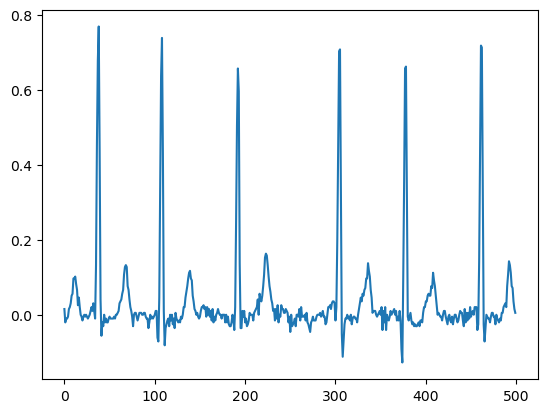

2-11
(AFIB


In [ ]:
import matplotlib.pyplot as plt
index=238000
plt.plot(segmented_ecg[index])
plt.show()
print(segmented_pt[index])
print(segmented_aux_label[index])

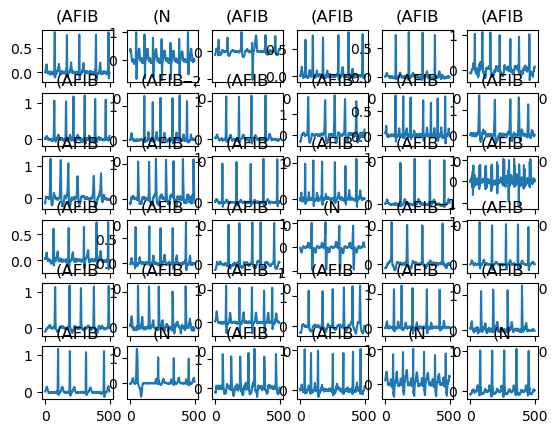

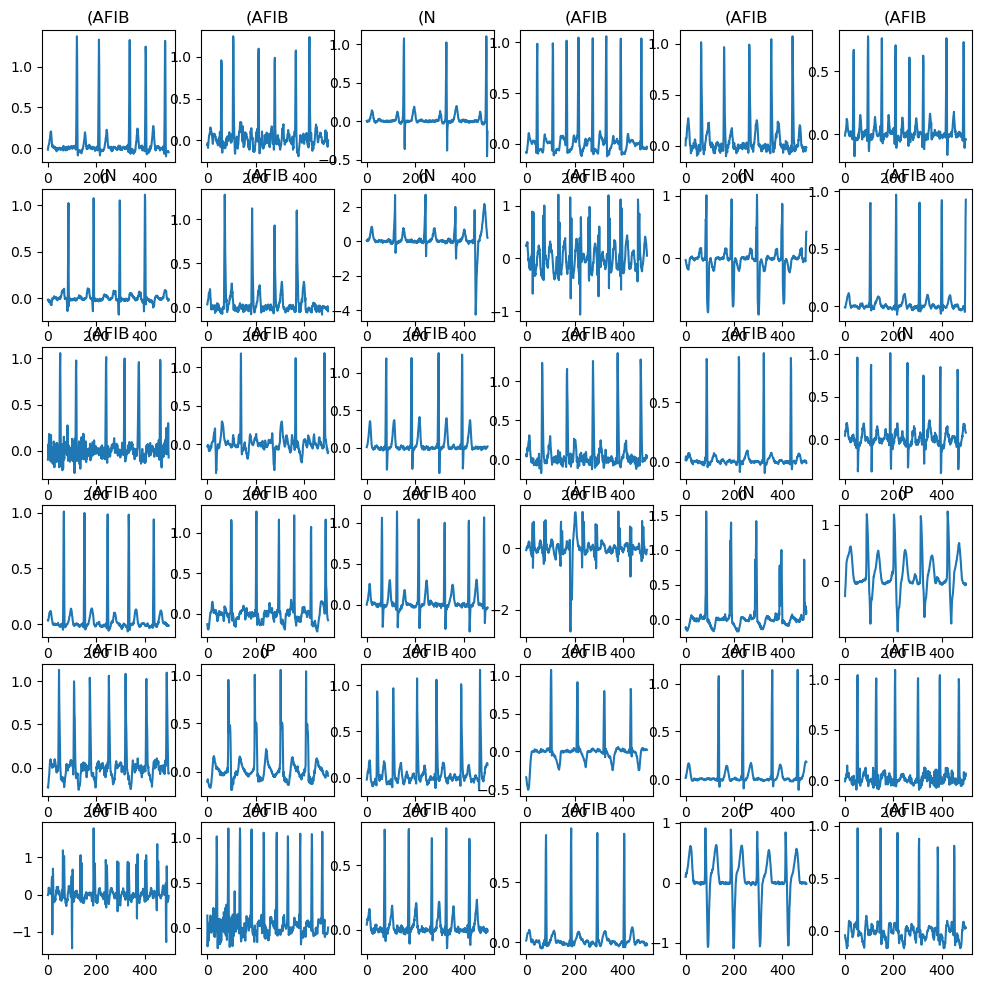

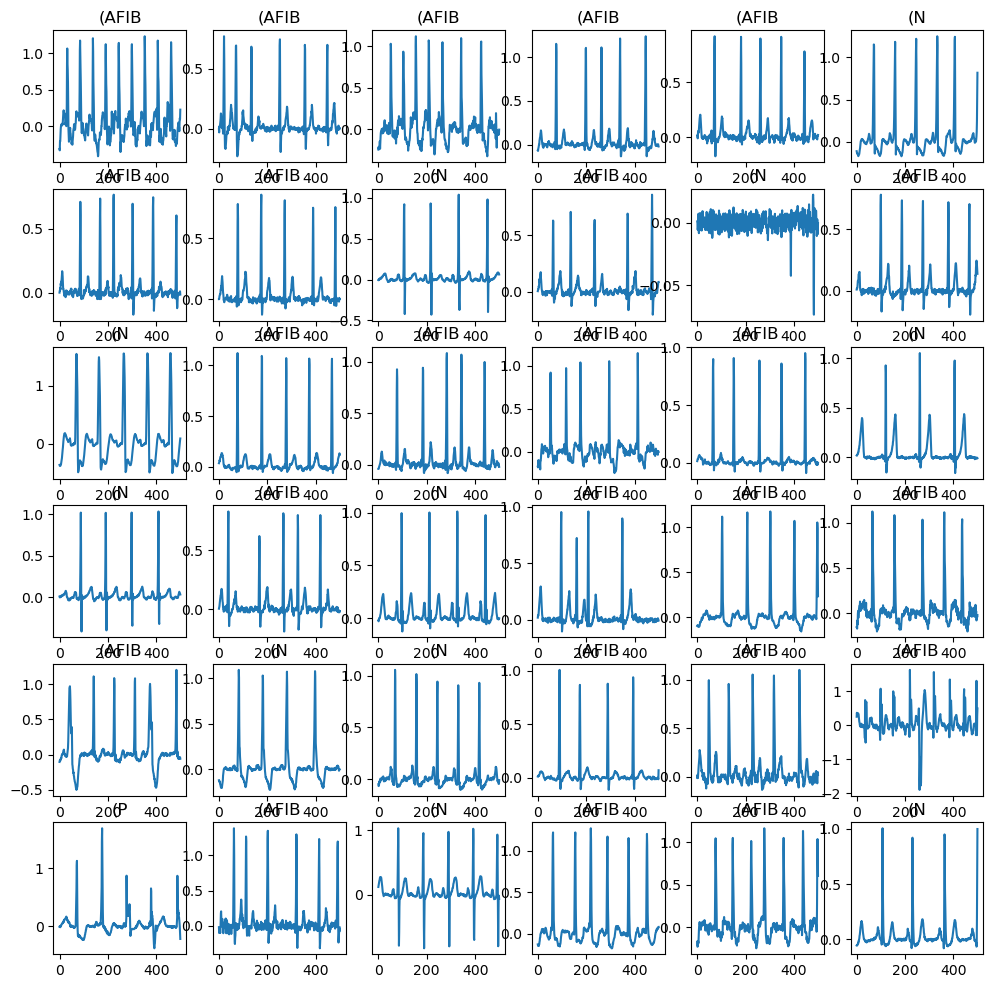

In [ ]:
fig,ax=plt.subplots(6,6,figsize=(12,12))
for i in range (6):
    for j in range (6):
        index=random.randrange(0,330000)
        ax[i,j].plot(segmented_ecg[index])
        ax[i,j].set_title(segmented_aux_label[index])
plt.show()

In [ ]:
np.unique(segmented_aux_label,return_counts=True)

(array(['(AFIB', '(AFL', '(B', '(N', '(P', '(PREX', '(SVTA', '(T', '(VT'],
       dtype='<U32'),
 array([3249967,    1099,   10687,   75626,    7680,     525,    6987,
           4752,     198], dtype=int64))

In [ ]:
# example conversion of neural net 1-hot coded output to class labels
Y_pred_code_ex = np.array([[0, .1 , 0, .1 , 0  , .6 , 0, .2, 0 ],
                           [0, .15, 0, .45, .05, .25, 0, 0 , .1]])
Y_pred_label_ex = encoder.inverse_transform(Y_pred_code_ex)
print('Classes:', encoder.classes_)
print('Predicted 1-hot code:', Y_pred_code_ex)
print('Predicted labels:', Y_pred_label_ex)

In [ ]:
# ecg_all = []
# ecg_length = 1000
# for ecg in final["ecg"]:
#   length = len(ecg)
#   if length <= ecg_length:
#     continue
#   counter = 0
#   while True:
#     x = ecg[ecg_length*counter: ecg_length*(counter+1)]
#     #we think with overlap is : x = ecg[200*counter : ecg_length + 200*counter]
#     ecg_all.append(x)
#     counter += 1
#     if ecg_length*(counter+1) > length:
#       break

In [ ]:
# np.asarray(ecg_all).shape

In [ ]:
# df = pd.DataFrame()
# df["aux"] = atr_aux
# indexes = df[df["aux"] == "(B\x00"].index

# res = pd.DataFrame()
# for index in indexes:
#   temp = df.iloc[index+1:,]
#   last_index = temp[temp["aux"] != ""].head(1).index[0]
#   res = res.append({"start": index, "end": last_index}, ignore_index=True)

# res

In [ ]:
atr_sample[82], atr_sample[96]

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(p_signal))
left = 19033
right = 22222
ab_index = [b for a, b in zip(atr_sym[82:96], atr_sample[82:96]) if a in abnormal]

plt.plot(x[left:right], p_signal[left:right, 0], '-', label='ecg')
plt.plot(x[atr_sample], p_signal[atr_sample, 0], 'go', label ='normal')
plt.plot(x[ab_index], p_signal[ab_index, 0], 'ro', label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right, 0].min() - 0.05, p_signal[left:right, 0].max() + 0.05)
plt.xlabel("time index")
plt.ylabel("ECG signal")
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

In [ ]:
for pt in pts:
  p_signal, atr_sym, atr_sample, atr_aux = load_ecg(data_path + pt)
  for index, aux in enumerate(atr_aux):
    if aux not in ["(T", "(B"]:
      continue
    indexes = np.where(np.array(atr_aux) != "")
    


In [ ]:
df = pd.DataFrame()

df['aux'] = aux
df['symbol'] = symbols

df['aux'] = df['aux'].apply(lambda x: x if x != '' else None)
df['aux'] = df['aux'].fillna(method='ffill')


In [ ]:
groups = df.groupby('aux')
counter = 1
for a, res in groups:
  res.to_csv(str(counter) + ".csv", index=False)
  counter += 1

In [ ]:
np.unique(df["aux"].values, return_counts=True)

In [ ]:
annotation.sym_to_aux()

In [ ]:
annotation.aux_note

plot ecg signal with normal and abnormal beats



In [ ]:
from matplotlib import pyplot as plt

# get abnormal beat index
ab_index = [b for a, b in zip(atr_sym, atr_sample) if a in abnormal][:10]

x = np.arange(len(p_signal))

left = ab_index[4] - 1500
right = ab_index[4] + 1500

plt.plot(x[left:right], p_signal[left:right, 0], '-', label='ecg')
plt.plot(x[atr_sample], p_signal[atr_sample, 0], 'go', label ='normal')
plt.plot(x[ab_index], p_signal[ab_index, 0], 'ro', label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right, 0].min() - 0.05, p_signal[left:right, 0].max() + 0.05)
plt.xlabel("time index")
plt.ylabel("ECG signal")
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

In [ ]:
# get abnormal beat index
ab_index = [b for a, b in zip(atr_sym, atr_sample) if a in abnormal][:10]

x = np.arange(len(normalized_signal))

left = ab_index[4] - 1500
right = ab_index[4] + 1500

plt.plot(x[left:right], normalized_signal[left:right], '-', label='ecg')
plt.plot(x[atr_sample], normalized_signal[atr_sample], 'go', label ='normal')
plt.plot(x[ab_index], normalized_signal[ab_index], 'ro', label='abnormal')

plt.xlim(left,right)
plt.ylim(normalized_signal[left:right].min() - 0.05, normalized_signal[left:right].max() + 0.05)
plt.xlabel("time index")
plt.ylabel("ECG signal")
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

# Shorter Data

In [ ]:
msk = (segmented_aux_label != "(AFIB") & (segmented_aux_label != "(N")
x = segmented_ecg[msk, :]
label = segmented_aux_label[msk]
pt = segmented_pt[msk]

print(x.shape)
print(label.shape)
print(pt.shape)



# select only 10000 samples of (AFIB rhythm
msk = (segmented_aux_label == "(AFIB")
x_afib = segmented_ecg[msk, :]
label_afib = segmented_aux_label[msk]
pt_afib = segmented_pt[msk]

indices = np.random.choice(x_afib.shape[0], 10000, replace=False)

x_afib = x_afib[indices,:]
label_afib = label_afib[indices]
pt_afib = pt_afib[indices]

print()
print(x_afib.shape)
print(label_afib.shape)
print(pt_afib.shape)



# select only 10000 samples of (N rhythm
msk = (segmented_aux_label == "(N")
x_n = segmented_ecg[msk, :]
label_n = segmented_aux_label[msk]
pt_n = segmented_pt[msk]

indices = np.random.choice(x_afib.shape[0], 10000, replace=False)

x_n = x_n[indices,:]
label_n = label_n[indices]
pt_n = pt_n[indices]

print()
print(x_n.shape)
print(label_n.shape)
print(pt_n.shape)



# concat all rhythms
X       = np.concatenate((x, x_afib, x_n))
label   = np.concatenate((label, label_afib, label_n))
pt      = np.concatenate((pt, pt_afib, pt_n))
encoder = LabelBinarizer()
y       = encoder.fit_transform(label)

print()
print(X.shape)
print(label.shape)
print(pt.shape)
print(y.shape)

# save shorter data to disk
np.save('data/X.npy'    , X)
np.save('data/label.npy', label)
np.save('data/pt.npy'   , pt)

(31928, 500)
(31928,)
(31928,)

(10000, 500)
(10000,)
(10000,)

(10000, 500)
(10000,)
(10000,)

(51928, 500)
(51928,)
(51928,)
(51928, 9)


In [7]:
# hamidreza
!unzip /content/drive/MyDrive/data\ for\ loading.zip -d /content/
!mv /content/data\ for\ loading /content/data

Archive:  /content/drive/MyDrive/data for loading.zip
replace /content/data for loading/label.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data for loading/pt.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: none
replace /content/data for loading/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [8]:
# load shorter data from disk instead of calculating from scratch
X       = np.load('data/X.npy')
label   = np.load('data/label.npy')
pt      = np.load('data/pt.npy')
encoder = LabelBinarizer()
y       = encoder.fit_transform(label)

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

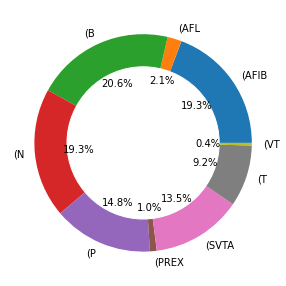

In [11]:
labels,counts = np.unique(label, return_counts=True)
plt.figure(figsize=(10, 5))
my_circle=plt.Circle((0, 0), 0.7, color='white')
plt.pie(counts, labels=labels, autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Generate Train/Test Dataset

In [ ]:
for lab in ['(AFL', '(P', '(PREX', '(VT']:
    print(lab, np.unique(p[label == lab], return_counts=True))
    
# when splitting by patient, always put these patients in train and test
# to have a reasonable distribution of rhythms between them
PTS_TRAIN = ['1-102', '1-107', '1-203', '1-222', '1-223']
PTS_TEST = ['1-104', '1-202', '1-205', '1-217', '2-203', '2-204', '2-207', '2-49']
# since only one patient has the (PREX rhythm,
# have no choice but to split this patient's data by sampe
PTS_PREX = ['1-230']

In [15]:
def split_by_patient(X, y, pts, test_size=.15, seed=42):
    random.seed(seed)
    
    # when splitting by patient, always put these patients in train and test
    # to have a reasonable distribution of rhythms between them
    pts_unique = np.unique(pts)
    pts_unique = pts_unique[~np.isin(pts_unique, PTS_TRAIN) & ~np.isin(pts_unique, PTS_TEST) & ~np.isin(pts_unique, PTS_PREX)]
    pts_train = np.random.choice(pts_unique, int((1-test_size)*len(pts_unique)), replace=False)
    pts_train = np.append(pts_train, PTS_TRAIN)
    pts_test = np.array(list(set(pts_unique) - set(pts_train)))
    pts_test = np.append(pts_test, PTS_TEST)

    msk_train = np.isin(pts, pts_train)
    msk_test = np.isin(pts, pts_test)
    X_train, X_test = X[msk_train, :], X[msk_test, :]
    y_train, y_test = y[msk_train, :], y[msk_test, :]
    
    # since only one patient has the (PREX rhythm,
    # have no choice but to split this patient's data by sampe
    msk_prex = np.isin(pts, PTS_PREX)
    X_prex, y_prex = X[msk_prex, :], y[msk_prex, :]
    X_train_prex, X_test_prex, y_train_prex, y_test_prex = train_test_split(X_prex, y_prex,
                                                                            test_size=test_size, random_state=seed)
    X_train = np.r_[X_train, X_train_prex]
    y_train = np.r_[y_train, y_train_prex]
    X_test = np.r_[X_test, X_test_prex]
    y_test = np.r_[y_test, y_test_prex]

    X_train, y_train = shuffle(X_train, y_train, random_state=seed)
    X_test, y_test = shuffle(X_test, y_test, random_state=seed)

    return X_train, X_test, y_train, y_test

def split_by_rhythm(X, y, labels, test_size=.15, seed=42):
    return train_test_split(X, y, test_size=test_size,
                            stratify=labels, random_state=seed)

def prep_data(X_train, X_test, y_train, y_test):
    # reshape input to be [samples, time steps, features = 1]
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    print('Train size:', X_train.shape, 'and', y_train.shape)
    print('Test  size:', X_test.shape, 'and', y_test.shape)
    print()

    # classes, counts = np.unique(y_train, return_counts=True)
    classes = encoder.classes_
    train_counts = y_train.sum(axis=0)
    test_counts = y_test.sum(axis=0)
    train_percentage = train_counts / train_counts.sum() * 100
    test_percentage = test_counts / test_counts.sum() * 100
    train_class_weight = dict(zip(range(y_train.shape[1]), train_counts.sum() / train_counts))
    test_class_weight = dict(zip(range(y_test.shape[1]), test_counts.sum() / test_counts))
    test_sample_weight = np.vectorize(test_class_weight.get)(
        np.vectorize(dict(zip(classes, range(len(classes)))).get)(
            encoder.inverse_transform(y_test)))

    print('Classes:', classes)
    print('Train class counts:', train_counts)
    print('Train class percentages:', train_percentage)
    print('Train class weights:', train_class_weight)
    print('Test class counts:', test_counts)
    print('Test class percentages:', test_percentage)
    print('Test class weights:', test_class_weight)
    
    return X_train_cnn, X_test_cnn, train_class_weight, test_sample_weight

# Models

In [16]:
# helper functions
def train_model(model, name='', *args, **kwargs):
    '''
    Train and save model to disk
    Resume training if model has been already trained
    '''
    
    if hasattr(model, 'all_history'):
        print('Resuming training (redefine model if need to train from scratch)')
        kwargs['initial_epoch'] = len(model.all_history['loss'])
        prev_history = model.all_history
    else:
        kwargs['initial_epoch'] = 0
        prev_history = {}
    
    if 'epochs' in kwargs:
        kwargs['epochs'] += kwargs['initial_epoch']
        
    def append_history():
        if not model.history.history:
            return
        new_history = model.history.history
        if prev_history:
            for k in prev_history:
                new_history[k] = prev_history[k] + new_history[k]
        model.all_history = new_history
    
    try:
        model.fit(*args, **kwargs)
        append_history()
        if name: save_model(model, name)
        
    except KeyboardInterrupt:
        print()
        print('Training interrupted by user')
        if name: print('Model not saved')
        append_history()
        
    except:
        append_history()
        raise
    
def save_model(model, name):
    model.save(f'models/{name}')
    with open('models/{name}_history.pkl', 'wb') as f:
        pickle.dump(model.all_history, f)
    print(f'Saved model to models/{name}')

def load_model(name):
    model = tf.keras.models.load_model(f'models/{name}')
    model.all_history = pickle.load(open('models/{name}_history.pkl', 'rb'))
    print(f'Loaded model from models/{name}')
    return model

def plot_history(model):
    acc = model.all_history['accuracy']
    val_acc = model.all_history['val_accuracy']

    loss = model.all_history['loss']
    val_loss = model.all_history['val_loss']
    
    epochs = np.arange(1, len(acc)+1)

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

def plot_confusion_matrix(model):
    y_train_pred = model.predict(X_train_cnn)
    y_test_pred = model.predict(X_test_cnn)

    y_test_pred_labels = encoder.inverse_transform(y_test_pred)
    y_test_labels = encoder.inverse_transform(y_test)

    cm = confusion_matrix(y_test_labels, y_test_pred_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test_labels),
                yticklabels=np.unique(y_test_labels))
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.show()

## Conv + LSTM (By Rhythm)

In [17]:
# split by rhythm
X_train, X_test, y_train, y_test = split_by_rhythm(X, y, label)
X_train_cnn, X_test_cnn, train_class_weight, test_sample_weight = prep_data(X_train, X_test, y_train, y_test)

Train size: (44138, 500) and (44138, 9)
Test  size: (7790, 500) and (7790, 9)

Classes: ['(AFIB' '(AFL' '(B' '(N' '(P' '(PREX' '(SVTA' '(T' '(VT']
Train class counts: [8500  934 9084 8500 6528  446 5939 4039  168]
Train class percentages: [19.25778241  2.11609044 20.58090534 19.25778241 14.78997689  1.01046717
 13.45552585  9.15084508  0.38062441]
Train class weights: {0: 5.192705882352941, 1: 47.25695931477516, 2: 4.858872743284897, 3: 5.192705882352941, 4: 6.761335784313726, 5: 98.96412556053812, 6: 7.431890890722344, 7: 10.92795246348106, 8: 262.7261904761905}
Test class counts: [1500  165 1603 1500 1152   79 1048  713   30]
Test class percentages: [19.25545571  2.11810013 20.57766367 19.25545571 14.78818999  1.01412067
 13.45314506  9.15275995  0.38510911]
Test class weights: {0: 5.193333333333333, 1: 47.21212121212121, 2: 4.859638178415471, 3: 5.193333333333333, 4: 6.762152777777778, 5: 98.60759493670886, 6: 7.433206106870229, 7: 10.925666199158485, 8: 259.6666666666667}


In [18]:
dropout = .1

inp = Input(shape=(X_train_cnn.shape[1], 1))
x = Conv1D(filters=64, kernel_size=50, activation='relu', padding="same")(inp)
x = MaxPool1D(pool_size=20, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = Conv1D(filters=32, kernel_size=10, activation='relu', padding="same")(x)
x = MaxPool1D(pool_size=10, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = Conv1D(filters=16, kernel_size=5, activation='relu', padding="same")(x)
x = MaxPool1D(pool_size=5, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = LSTM(32, dropout=dropout)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=dropout)(x)
x = Dense(16, activation='relu')(x)
out = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile(loss='categorical_crossentropy', optimizer=Adam(.0001), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 64)           3264      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 32)           20512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 32)           0     

In [20]:
train_model(model, 'conv_lstm',
            X_train_cnn, y_train, class_weight=train_class_weight,
            validation_data=(X_test_cnn, y_test, test_sample_weight),
            batch_size=32, epochs=100)

Resuming training (redefine model if need to train from scratch)
Epoch 9/10
1380/1380 [==============================] - 36s 26ms/step - loss: 4.5391 - accuracy: 0.7608 - val_loss: 3.9840 - val_accuracy: 0.7639
Epoch 10/10
1380/1380 [==============================] - 35s 25ms/step - loss: 3.9972 - accuracy: 0.7856 - val_loss: 3.7586 - val_accuracy: 0.8042


INFO:tensorflow:Assets written to: models/conv_lstm/assets


INFO:tensorflow:Assets written to: models/conv_lstm/assets


Saved model to models/conv_lstm


In [21]:
model = load_model('conv_lstm')

Loaded model from models/conv_lstm


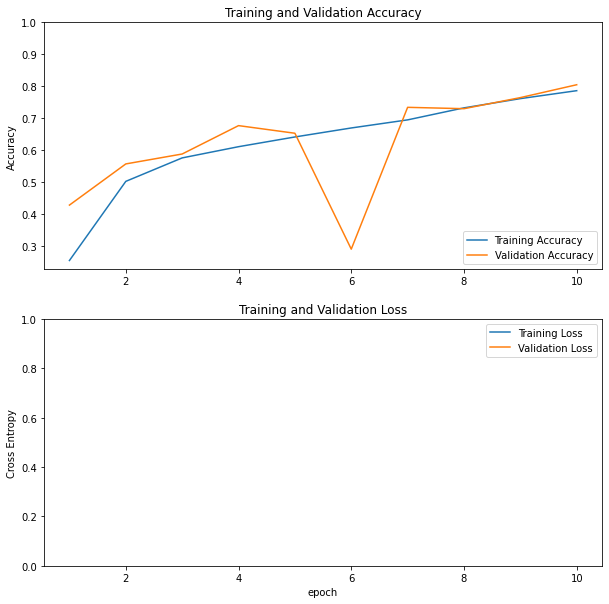

In [22]:
plot_history(model)

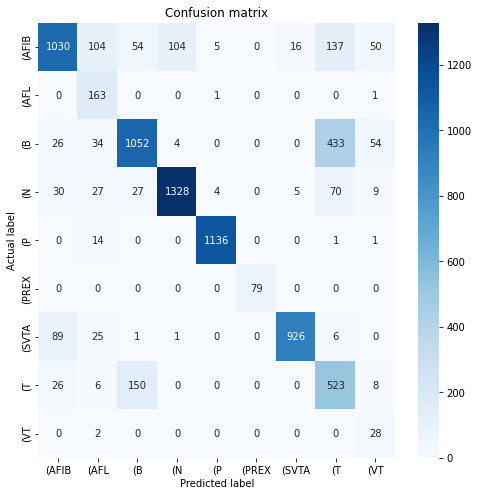

In [23]:
plot_confusion_matrix(model)

In [24]:
# hamidreza
y_test_pred = model.predict(X_test_cnn)

In [28]:
# hamidreza
from sklearn.metrics import roc_curve, auc, roc_auc_score

n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

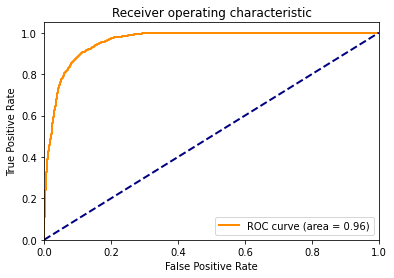

In [29]:
# hamidreza
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


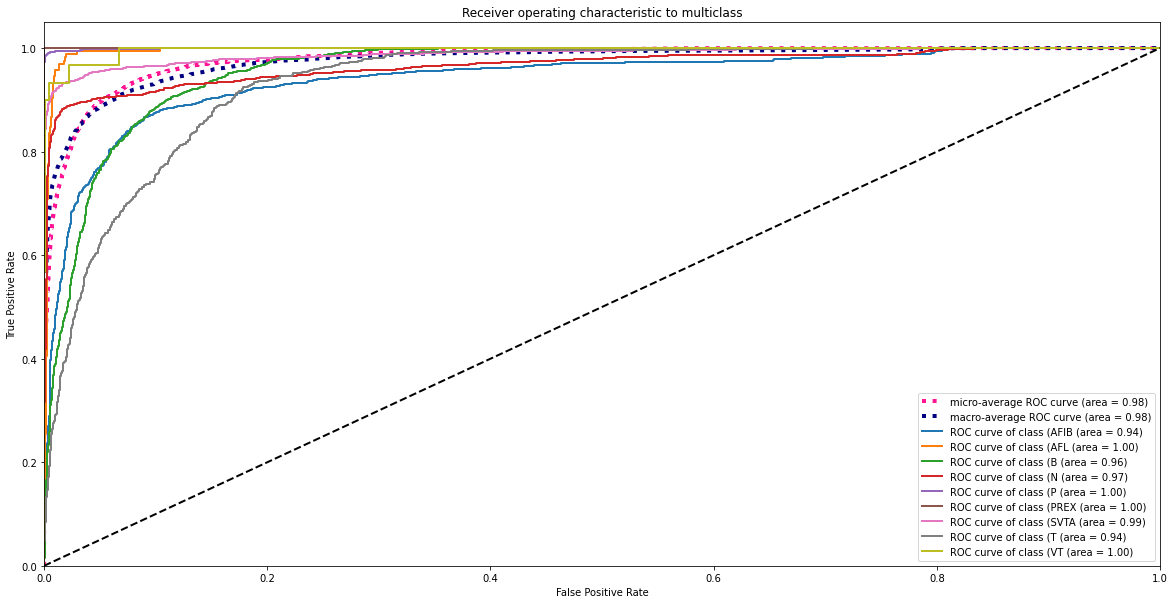

In [45]:
# hamidreza
from scipy import interp
from itertools import cycle


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(encoder.classes_[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## CNN (By Patient)

In [ ]:
# split by patient
X_train, X_test, y_train, y_test = split_by_patient(X, y, pt)
X_train_cnn, X_test_cnn, train_class_weight, test_sample_weight = prep_data(X_train, X_test, y_train, y_test)

Train size: (101567, 500) and (101567, 9)
Test  size: (15987, 500) and (15987, 9)

Classes: ['(AFIB' '(AFL' '(B' '(N' '(P' '(PREX' '(SVTA' '(T' '(VT']
Train class counts: [ 7860  1004 10578 65774  4202   453  6882  4662   152]
Train class percentages: [ 7.73873404  0.98851005 10.41480008 64.75922298  4.13717054  0.44601101
  6.77582286  4.59007355  0.14965491]
Train class weights: {0: 12.922010178117048, 1: 101.16235059760956, 2: 9.601720552089242, 3: 1.5441815915103232, 4: 24.171108995716324, 5: 224.20971302428256, 6: 14.75835512932287, 7: 21.786143286143286, 8: 668.203947368421}
Test class counts: [2140   95  109 9852 3478   72  105   90   46]
Test class percentages: [13.38587602  0.59423281  0.68180397 61.62507037 21.75517608  0.45036592
  0.65678364  0.5629574   0.28773378]
Test class weights: {0: 7.470560747663551, 1: 168.2842105263158, 2: 146.6697247706422, 3: 1.6227161997563946, 4: 4.5966072455434155, 5: 222.04166666666666, 6: 152.25714285714287, 7: 177.63333333333333, 8: 347.54

In [ ]:
dropout = 0.05

inp = Input(shape=(X_train_cnn.shape[1], 1))
x = Conv1D(filters=64, kernel_size=50, activation='relu', padding="same")(inp)
x = MaxPool1D(pool_size=10, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = Conv1D(filters=32, kernel_size=10, activation='relu', padding="same")(x)
x = MaxPool1D(pool_size=5, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = Conv1D(filters=16, kernel_size=5, activation='relu', padding="same")(x)
x = MaxPool1D(pool_size=5, strides=2, padding="same")(x)
x = Dropout(rate=dropout)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=dropout)(x)
x = Dense(16, activation='relu')(x)
out = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile(loss='categorical_crossentropy', optimizer=Adam(.0001), metrics=['accuracy'])

model.summary()

Model: "functional_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 500, 1)]          0         
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 500, 64)           3264      
_________________________________________________________________
max_pooling1d_172 (MaxPoolin (None, 250, 64)           0         
_________________________________________________________________
dropout_218 (Dropout)        (None, 250, 64)           0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 250, 32)           20512     
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 125, 32)           0         
_________________________________________________________________
dropout_219 (Dropout)        (None, 125, 32)        

In [ ]:
train_model(model, 'conv',
            X_train_cnn, y_train, class_weight=train_class_weight,
            validation_data=(X_test_cnn, y_test, test_sample_weight),
            batch_size=32, epochs=70)

Epoch 1/70
3174/3174 [==============================] - 13s 4ms/step - loss: 11.0813 - accuracy: 0.4277 - val_loss: 14.8382 - val_accuracy: 0.4121
Epoch 2/70
3174/3174 [==============================] - 12s 4ms/step - loss: 5.4817 - accuracy: 0.6836 - val_loss: 19.3236 - val_accuracy: 0.6907
Epoch 3/70
3174/3174 [==============================] - 11s 4ms/step - loss: 3.8983 - accuracy: 0.7709 - val_loss: 21.4562 - val_accuracy: 0.6547
Epoch 4/70
3174/3174 [==============================] - 11s 4ms/step - loss: 3.0361 - accuracy: 0.8192 - val_loss: 22.0852 - val_accuracy: 0.8022
Epoch 5/70
3174/3174 [==============================] - 11s 4ms/step - loss: 2.4311 - accuracy: 0.8534 - val_loss: 20.1584 - val_accuracy: 0.8160
Epoch 6/70
3174/3174 [==============================] - 11s 4ms/step - loss: 2.0887 - accuracy: 0.8736 - val_loss: 22.7229 - val_accuracy: 0.8339
Epoch 7/70
3174/3174 [==============================] - 11s 3ms/step - loss: 1.8055 - accuracy: 0.8874 - val_loss: 26.3029 

In [ ]:
model = load_model('conv')

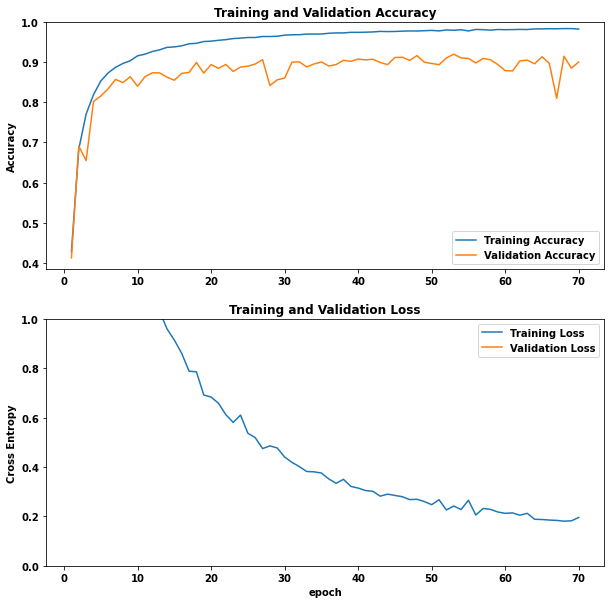

In [ ]:
plot_history(model)

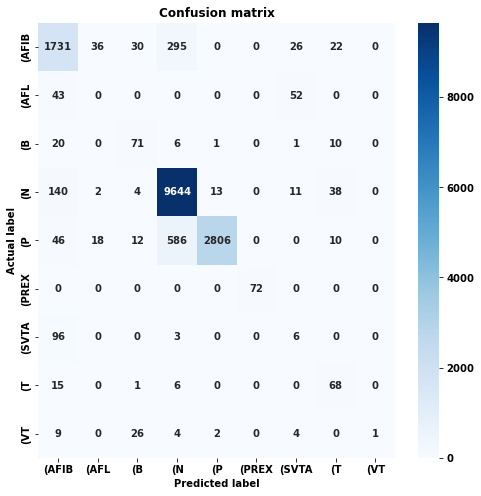

In [ ]:
plot_confusion_matrix(model)

## Compare

In [ ]:
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 9

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='blue', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='blue', label='Class 5 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   

NameError: name 'pred_prob' is not defined

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_test_cnn, tpr_test_cnn, t_test_cnn = roc_curve(y_test, y_test_pred_cnn)
auc_test_cnn = roc_auc_score(y_test, y_test_pred_cnn)

fpr_test_dense, tpr_test_dense, t_test_dense = roc_curve(y_test, y_test_pred_dense)
auc_test_dense = roc_auc_score(y_test, y_test_pred_dense)

fpr_test_lstm, tpr_test_lstm, t_test_lstm = roc_curve(y_test, y_test_pred_lstm)
auc_test_lstm = roc_auc_score(y_test, y_test_pred_lstm)

plt.plot(fpr_test_cnn, tpr_test_cnn, 'g-', label='CNN AUC:%.3f'%auc_test_cnn)
plt.plot(fpr_test_dense, tpr_test_dense, 'r-', label='Dense AUC:%.3f'%auc_test_dense)
plt.plot(fpr_test_lstm, tpr_test_lstm, 'b-', label='LSTM AUC:%.3f'%auc_test_lstm)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.title('Test Set')
plt.show()